In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error as mse

In [2]:

def getDataFrame():
    full_dataUnpickled = pd.read_pickle("../dataSingleOrbitNew.pkl")
    full_dataUnpickled = full_dataUnpickled.drop(columns=["xdotdot", "ydotdot", "zdotdot", "ecc",  "inc", "alt"], axis =1)
    full_dataUnpickled['timeAux'] = full_dataUnpickled['time'].transform(lambda x: x - x.min())
    full_dataUnpickled['timeAux'] = full_dataUnpickled['timeAux'] + 1577836800
    full_dataUnpickled['datetime'] = pd.to_datetime(full_dataUnpickled['timeAux'], unit='s')
    #select data from one orbit id
    # full_dataUnpickled = full_dataUnpickled[full_dataUnpickled['orbit_id'] == "1"]
    full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot"]] = full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot"]]/1000
    full_dataUnpickled = full_dataUnpickled.drop(columns=["time", "timeAux"], axis =1)
    #set datetime as index 
    full_dataUnpickled = full_dataUnpickled.set_index('datetime')
    
    #TODO cut to 5k lines for testing 
    # full_dataUnpickled = full_dataUnpickled[:5000]
    
    return full_dataUnpickled

dataframe = getDataFrame()
print(dataframe.head())

def df_to_X_y(df, window_size=300):
    #usar x, y, z, xdot, ydot, zdot em 1 || x, y, z, xdot, ydot, zdot em 2 || x, y, z, xdot, ydot, zdot em 3 || x, y, z, xdot, ydot, zdot em 4 || x, y, z, xdot, ydot, zdot em 5 => para prever x em 7
    #usar x, y, z, xdot, ydot, zdot em 2 || x, y, z, xdot, ydot, zdot em 3 || x, y, z, xdot, ydot, zdot em 4 || x, y, z, xdot, ydot, zdot em 5 || x, y, z, xdot, ydot, zdot em 6 => para prever x em 7
    #usar x, y, z, xdot, ydot, zdot em 3 || x, y, z, xdot, ydot, zdot em 4 || x, y, z, xdot, ydot, zdot em 5 || x, y, z, xdot, ydot, zdot em 6 || x, y, z, xdot, ydot, zdot em 7 => para prever x em 8
    # [[[x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot]]] [6]
    # [[[x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot]]] [7]
    # [[[x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot], [x, y, z, xdot, ydot, zdot]]] [8]

    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2], df_as_np[i+window_size][3], df_as_np[i+window_size][4], df_as_np[i+window_size][5]] 
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2000
X, y = df_to_X_y(dataframe, window_size=WINDOW_SIZE)
#change all columns except datetime to float

print(X.shape) # (2870, 11, 8) (numero de training samples, tamanho da window, nr de colunas)
print(y.shape) # (2870,) (numero de training samples), terá mais uma dimensao caso prever todas as vars


                               x          y           z      xdot      ydot  \
datetime                                                                      
2020-01-01 00:00:00  7304.355095   0.000000    0.000000 -0.000000  1.289166   
2020-01-01 00:00:05  7304.261594   6.445802   36.555963 -0.037401  1.289149   
2020-01-01 00:00:10  7303.981092  12.891439   73.110985 -0.074800  1.289100   
2020-01-01 00:00:15  7303.513597  19.336745  109.664129 -0.112198  1.289017   
2020-01-01 00:00:20  7302.859121  25.781554  146.214456 -0.149592  1.288901   

                         zdot  
datetime                       
2020-01-01 00:00:00  7.311224  
2020-01-01 00:00:05  7.311130  
2020-01-01 00:00:10  7.310848  
2020-01-01 00:00:15  7.310378  
2020-01-01 00:00:20  7.309721  
(15281, 2000, 6)
(15281, 6)


In [3]:

X_train, y_train = X[:9000], y[:9000]
X_val, y_val = X[9000:11000], y[9000:11000]
X_test, y_test = X[11000:], y[11000:]

#TODO just to try if runs
# X_train, y_train = X[:3000], y[:3000]
# X_val, y_val = X[3000:4200], y[3000:4200]
# X_test, y_test = X[4200:], y[4200:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

#standardizar variaveis
x_training_mean = np.mean(X_train[:, :, 0])
x_training_std = np.std(X_train[:, :, 0])

y_training_mean = np.mean(X_train[:, :, 1])
y_training_std = np.std(X_train[:, :, 1])

z_training_mean = np.mean(X_train[:, :, 2])
z_training_std = np.std(X_train[:, :, 2])

xdot_training_mean = np.mean(X_train[:, :, 3])
xdot_training_std = np.std(X_train[:, :, 3])

ydot_training_mean = np.mean(X_train[:, :, 4])
ydot_training_std = np.std(X_train[:, :, 4])

zdot_training_mean = np.mean(X_train[:, :, 5])
zdot_training_std = np.std(X_train[:, :, 5])


def preprocessInput(X):
    X[:, :, 0] = (X[:, :, 0] - x_training_mean)/x_training_std
    X[:, :, 1] = (X[:, :, 1] - y_training_mean)/y_training_std
    X[:, :, 2] = (X[:, :, 2] - z_training_mean)/z_training_std
    X[:, :, 3] = (X[:, :, 3] - xdot_training_mean)/xdot_training_std
    X[:, :, 4] = (X[:, :, 4] - ydot_training_mean)/ydot_training_std
    X[:, :, 5] = (X[:, :, 5] - zdot_training_mean)/zdot_training_std
    return X

def preprocessOutput(y):
    y[:, 0] = (y[:, 0] - x_training_mean)/x_training_std
    y[:, 1] = (y[:, 1] - y_training_mean)/y_training_std
    y[:, 2] = (y[:, 2] - z_training_mean)/z_training_std
    y[:, 3] = (y[:, 3] - xdot_training_mean)/xdot_training_std
    y[:, 4] = (y[:, 4] - ydot_training_mean)/ydot_training_std
    y[:, 5] = (y[:, 5] - zdot_training_mean)/zdot_training_std
    return y

X_train_preprocessed = preprocessInput(X_train)
X_val_preprocessed = preprocessInput(X_val)
X_test_preprocessed = preprocessInput(X_test)

y_train_preprocessed = preprocessOutput(y_train)
y_val_preprocessed = preprocessOutput(y_val)
y_test_preprocessed = preprocessOutput(y_test)

In [4]:
np.shape(X_test_preprocessed)

(4281, 2000, 6)

In [8]:
def create_model():
    model = Sequential()
    #windowsize, nr columns
    model.add(InputLayer((WINDOW_SIZE, 6)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dense(6, 'linear'))

    model.summary()

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()],  run_eagerly=True)
    return model


In [6]:
model = create_model()
checkpoint_path = "training_1_lstm/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(X_train_preprocessed, y_train_preprocessed, validation_data=(X_val_preprocessed, y_val_preprocessed), epochs=2, callbacks=[cp_callback], batch_size=32)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 18,750
Trainable params: 18,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
106/282 [==========>...................] - ETA: 10:37 - loss: 0.3088 - root_mean_squared_error: 0.5557

KeyboardInterrupt: 

In [ ]:
#save the model to use later without training
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)


model.save('savedmodels/savedmodel1')
new_model = tf.keras.models.load_model('savedmodels/savedmodel1')

loss, acc = model.evaluate(X_test_preprocessed, y_test_preprocessed, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

INFO:tensorflow:Assets written to: savedmodels/savedmodel1\assets


INFO:tensorflow:Assets written to: savedmodels/savedmodel1\assets


134/134 - 172s - loss: 6.6676e-04 - root_mean_squared_error: 0.0258 - 172s/epoch - 1s/step
Restored model, accuracy:  2.58%


134/134 [==============================] - 170s 1s/step


<Figure size 640x480 with 0 Axes>

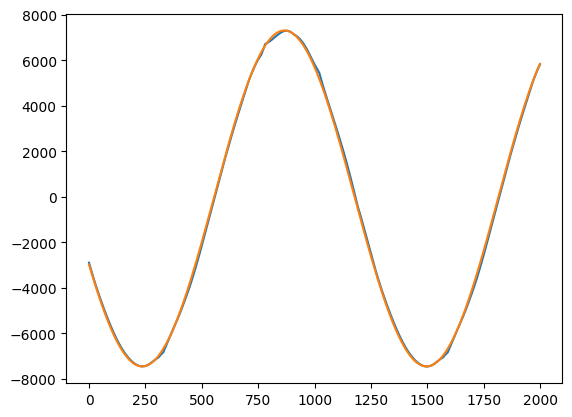

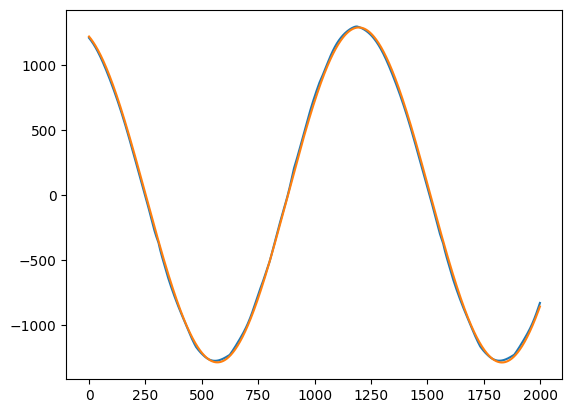

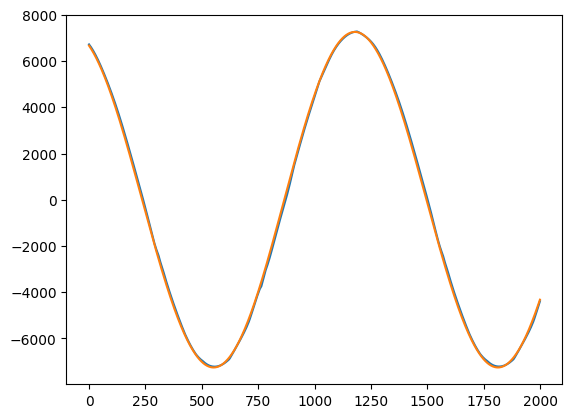

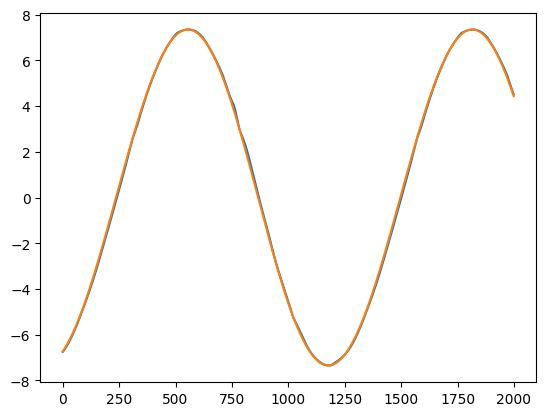

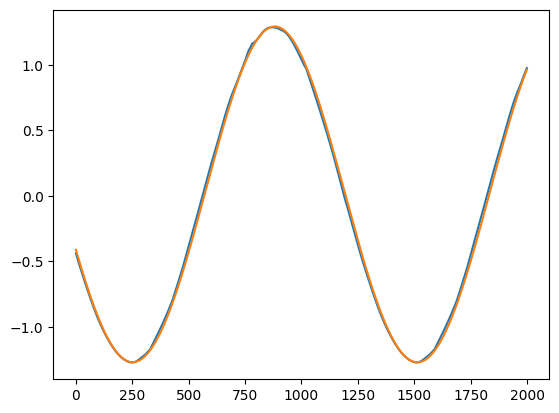

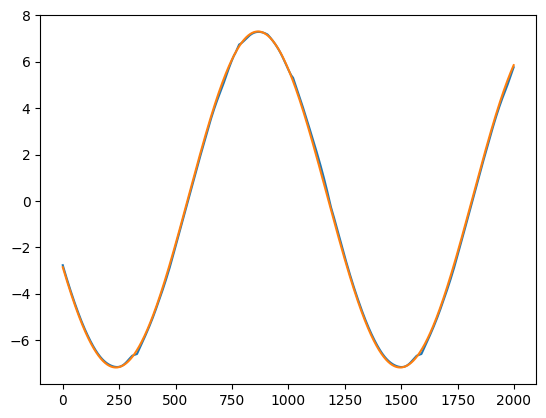

<Figure size 640x480 with 0 Axes>

In [ ]:

def postprocess_x(arr):
    arr = (arr*x_training_std) + x_training_mean
    return arr

def postprocess_y(arr):
    arr = (arr*y_training_std) + y_training_mean
    return arr

def postprocess_z(arr):
    arr = (arr*z_training_std) + z_training_mean
    return arr

def postprocess_xdot(arr):
    arr = (arr*xdot_training_std) + xdot_training_mean
    return arr

def postprocess_ydot(arr):
    arr = (arr*ydot_training_std) + ydot_training_mean
    return arr

def postprocess_zdot(arr):
    arr = (arr*zdot_training_std) + zdot_training_mean
    return arr

def plot_predictions(model, X, y, start=0, end=WINDOW_SIZE):
    predictions = model.predict(X)
    x_preds, y_preds, z_preds, xdot_preds, ydot_preds, zdot_preds = postprocess_x(predictions[:, 0]), \
                                                                    postprocess_y(predictions[:, 1]),\
                                                                    postprocess_z(predictions[:, 2]),\
                                                                    postprocess_xdot(predictions[:, 3]),\
                                                                    postprocess_ydot(predictions[:, 4]),\
                                                                    postprocess_zdot(predictions[:, 5])
    x_actuals, y_actuals, z_actuals, xdot_actuals, ydot_actuals, zdot_actuals = postprocess_x(y[:, 0]), \
                                                                            postprocess_y(y[:, 1]),\
                                                                            postprocess_z(y[:, 2]),\
                                                                            postprocess_xdot(y[:, 3]),\
                                                                            postprocess_ydot(y[:, 4]),\
                                                                            postprocess_zdot(y[:, 5])

    df = pd.DataFrame(data={'X Predictions': x_preds,
                            'X Actuals':x_actuals,
                            'Y Predictions': y_preds,
                            'Y Actuals': y_actuals,
                            'Z Predictions': z_preds,
                            'Z Actuals': z_actuals,
                            'XDOT Predictions': xdot_preds,
                            'XDOT Actuals': xdot_actuals,
                            'YDOT Predictions': ydot_preds,
                            'YDOT Actuals': ydot_actuals,
                            'ZDOT Predictions': zdot_preds,
                            'ZDOT Actuals': zdot_actuals
                            })

    return df

start, end = 0, WINDOW_SIZE
post_processed_plot = plot_predictions(model, X_test_preprocessed, y_test_preprocessed)
plt.figure()
plt.plot(post_processed_plot["X Predictions"][start:end])
plt.plot(post_processed_plot["X Actuals"][start:end])
plt.savefig("x_transformer.png")
plt.figure()
plt.plot(post_processed_plot["Y Predictions"][start:end])
plt.plot(post_processed_plot["Y Actuals"][start:end])
plt.savefig("y_transformer.png")
plt.figure()
plt.plot(post_processed_plot["Z Predictions"][start:end])
plt.plot(post_processed_plot["Z Actuals"][start:end])
plt.savefig("z_transformer.png")
plt.figure()
plt.plot(post_processed_plot["XDOT Predictions"][start:end])
plt.plot(post_processed_plot["XDOT Actuals"][start:end])
plt.savefig("xdot_transformer.png")
plt.figure()
plt.plot(post_processed_plot["YDOT Predictions"][start:end])
plt.plot(post_processed_plot["YDOT Actuals"][start:end])
plt.savefig("ydot_transformer.png")
plt.figure()
plt.plot(post_processed_plot["ZDOT Predictions"][start:end])
plt.plot(post_processed_plot["ZDOT Actuals"][start:end])
plt.savefig("zdot_transformer.png")
plt.figure()
# plt.show()

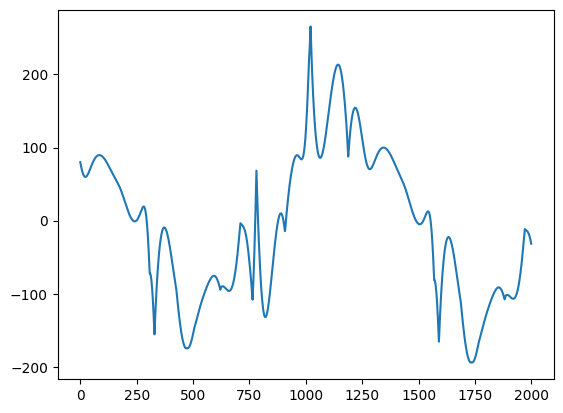

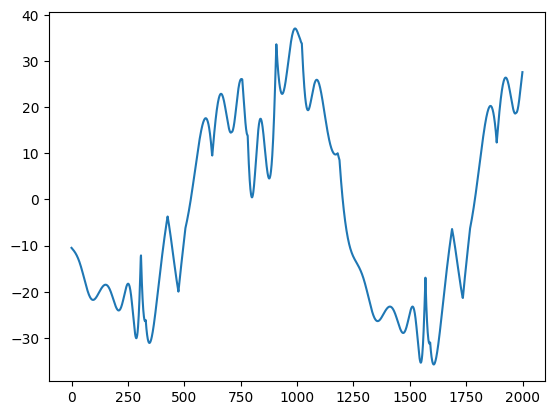

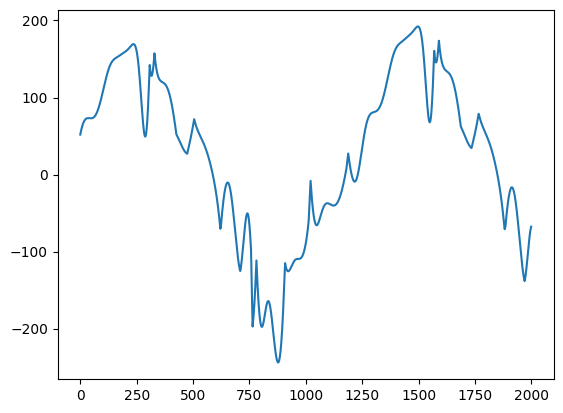

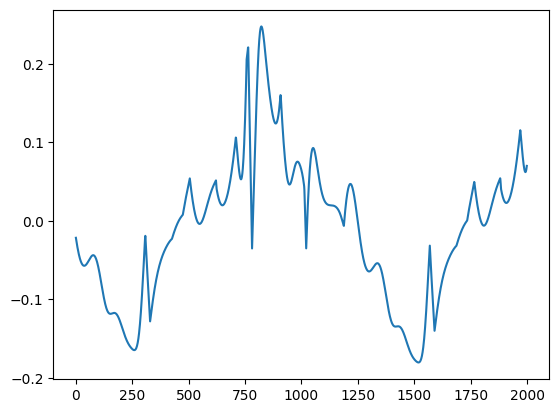

In [ ]:
#create graphs that represent the error of the model
def plot_error(dataframePredsActuals, end=WINDOW_SIZE):
    x_preds, y_preds, z_preds, xdot_preds, ydot_preds, zdot_preds = dataframePredsActuals["X Predictions"][start:end], \
                                                                    dataframePredsActuals["Y Predictions"][start:end],\
                                                                    dataframePredsActuals["Z Predictions"][start:end],\
                                                                    dataframePredsActuals["XDOT Predictions"][start:end],\
                                                                    dataframePredsActuals["YDOT Predictions"][start:end],\
                                                                    dataframePredsActuals["ZDOT Predictions"][start:end]
    x_actuals, y_actuals, z_actuals, xdot_actuals, ydot_actuals, zdot_actuals = dataframePredsActuals["X Actuals"][start:end], \
                                                                                dataframePredsActuals["Y Actuals"][start:end],\
                                                                                dataframePredsActuals["Z Actuals"][start:end],\
                                                                                dataframePredsActuals["XDOT Actuals"][start:end],\
                                                                                dataframePredsActuals["YDOT Actuals"][start:end],\
                                                                                dataframePredsActuals["ZDOT Actuals"][start:end]

    df = pd.DataFrame(data={'X Error': x_preds-x_actuals,
                            'Y Error': y_preds-y_actuals,
                            'Z Error': z_preds-z_actuals,
                            'XDOT Error': xdot_preds-xdot_actuals,
                            'YDOT Error': ydot_preds-ydot_actuals,
                            'ZDOT Error': zdot_preds-zdot_actuals
                            })
    return df[start:end]

post_processed_error = plot_error(post_processed_plot)
plt.figure()
plt.plot(post_processed_error["X Error"])
# plt.savefig("x_error_transformer.png")
plt.figure()
plt.plot(post_processed_error["Y Error"])
plt.savefig("y_error_transformer.png")
plt.figure()
plt.plot(post_processed_error["Z Error"])
# plt.savefig("z_error_transformer.png")
plt.figure()
plt.plot(post_processed_error["XDOT Error"])
# plt.savefig("xdot_error_transformer.png")
# plt.figure()
# plt.plot(post_processed_error["YDOT Error"])
# plt.savefig("ydot_error_transformer.png")
# plt.figure()
# plt.plot(post_processed_error["ZDOT Error"])
# plt.savefig("zdot_error_transformer.png")
# plt.figure()


(4281,)


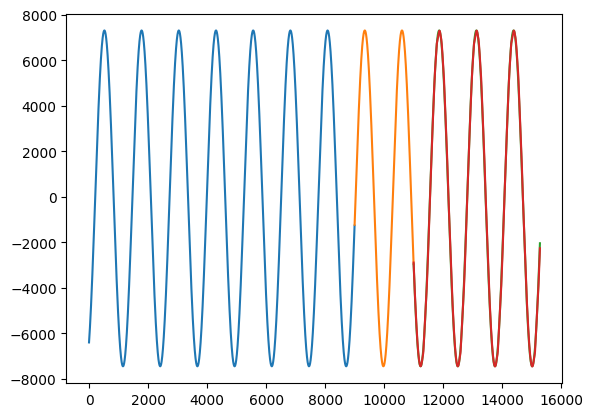

In [ ]:
#PLOT the train, validation and test X against time



plt.plot(postprocess_x(y_train[:,0]))
#start = last index of the training set
start = y_train.shape[0]
#end = last index of the validation set
end = start + y_val.shape[0]
plt.plot(np.arange(start, end), postprocess_x(y_val[:,0]))
#start = last index of the validation set
start = end
#end = last index of the test set
end = start + y_test.shape[0]
plt.plot(np.arange(start, end), postprocess_x(y_test[:,0]))
#plot the predictions for the test set
plt.plot(np.arange(start, end), post_processed_plot["X Predictions"].values)
print(np.shape(post_processed_plot["X Predictions"]))
plt.show()



1/1 [==============================] - 1s 1s/step


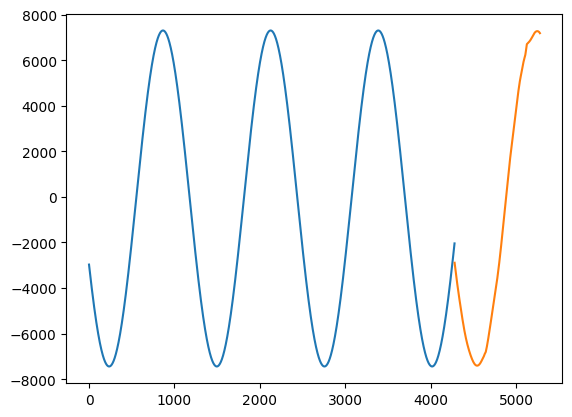

In [ ]:
#recursively predict the next 1000 points
def recursive_predict(model, X_test, y_test, num_predictions):
    #initialize the predictions
    predictions = np.zeros((num_predictions, 6))
    #initialize the current input
    current_input = X_test[0]
    for i in range(num_predictions):
        #predict the next point
        prediction = model.predict(current_input.reshape(1, WINDOW_SIZE, 6))
        #add the prediction to the list of predictions
        predictions[i] = prediction
        #add the prediction to the current input
        current_input = np.concatenate((current_input[1:], prediction), axis=0)
    return predictions

#predict the next 1000 points
num_predictions = 1000
predictionsRecursive = recursive_predict(model, X_test_preprocessed, y_test_preprocessed, num_predictions)
#postprocess the predictions

x_predsRecursive, y_predsRecursive, z_predsRecursive, xdot_predsRecursive, ydot_predsRecursive, zdot_predsRecursive = postprocess_x(predictionsRecursive[:, 0]), \
                                                                    postprocess_y(predictionsRecursive[:, 1]),\
                                                                    postprocess_z(predictionsRecursive[:, 2]),\
                                                                    postprocess_xdot(predictionsRecursive[:, 3]),\
                                                                    postprocess_ydot(predictionsRecursive[:, 4]),\
                                                                    postprocess_zdot(predictionsRecursive[:, 5])


#plot the predictions for the next timesteps against the previous timesteps
plt.plot(postprocess_x(y_test[:,0]))
plt.plot(np.arange(y_test.shape[0], y_test.shape[0]+num_predictions), x_predsRecursive)
plt.show()
# plt.plot(postprocess_y(y_test[:,1]))
# plt.plot(np.arange(y_test.shape[0], y_test.shape[0]+num_predictions), y_predsRecursive)
# plt.show()
# plt.plot(xdot_predsRecursive)
plt.show()
